In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as prog_bar

import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
# from tensorflow.keras.callbacks import ModelCheckpoint

### Random States
---

In [8]:
random_states =( 10,13,17,24,51)

In [9]:
cg = ('a','b','c','d') #categories

In [10]:
TTS_DICT = {
        'a':['50','50'],
        'b':['60',"40"],
        'c':['75','25'],
        'd':['80','20']
    }

TTS_DICT_INV = {
        '50':'a',
        '40':'b',
        '25':'c',
        '20':'d'    
    }

print(TTS_DICT_INV)

TTS_BASE_DIR = os.path.abspath('Train_Test_Data_Splits')
TTS_Folder_LIST = os.listdir(TTS_BASE_DIR)
print(TTS_Folder_LIST)

{'50': 'a', '40': 'b', '25': 'c', '20': 'd'}
['train_test_rs_10', 'train_test_rs_13', 'train_test_rs_17', 'train_test_rs_24', 'train_test_rs_51']


In [21]:
def get_train_test_xy():
    

    for tts_foldr in TTS_Folder_LIST:
        OHEs = {}
        Scalers = {}
        for x in cg:
            Scalers[x] = StandardScaler()
            OHEs[x] = OneHotEncoder()
        
        x_trains = {}
        y_trains= {}
        x_tests = {}
        y_tests = {}
        TTS_FILE_LIST = os.listdir(os.path.join(TTS_BASE_DIR,tts_foldr))
        for tts_file in TTS_FILE_LIST:
            tts_file_path = os.path.join(TTS_BASE_DIR,tts_foldr,tts_file)
            df = pd.read_csv(tts_file_path,index_col=False)
            tts_file_wo_ext = tts_file.split('.')[0].split('_')
            k = TTS_DICT_INV[tts_file_wo_ext[-1]]
            if 'train' in tts_file_wo_ext:
                #depend on test set size
                x_trains[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_trains[k] = np.expand_dims(x_trains[k], axis=2)
                y_trains[k]  = OHEs[k].fit_transform(df['Y_train'].values.reshape(-1,1)).toarray()
            else:
                x_tests[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_tests[k] = np.expand_dims(x_tests[k], axis=2)
                y_tests[k]  = OHEs[k].fit_transform( df['Y_test'].values.reshape(-1,1)).toarray()
        r_state = tts_foldr.split("_")[-1]
        yield (x_trains,y_trains,x_tests,y_tests,r_state)    
            
        

In [40]:

def loss_accuracy_details(model,history,epoch,x_test,y_test):
    acc = model.evaluate(x_test,y_test)[1]*100
    print(f"Accuracy of our model on test data :{acc:.2f} %")
    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()
    return acc

---
### Base Model Folder path
----

In [28]:
MODEL_BASE_DIR = os.path.abspath('Models')

---
## Model 1
----

In [31]:
def model_1(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

----
# Model 1 Traing For Different Train Test Split
  Train    |   Test
  - 50-50
  - 60-50
  - 75-25
  - 80-20
----

In [41]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1'))

In [61]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 35

In [62]:
model_1_acc_matrix = {}
for k in cg:
   model_1_acc_matrix[k]= list()
print(model_1_acc_matrix) 
 

{'a': [], 'b': [], 'c': [], 'd': []}


In [ ]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_train_test_xy(),total=5):
    Model_1_dict = {}
    Histories_1 = {}
    for k in cg:
        Model_1_dict[k] = model_1(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Histories_1[k] = Model_1_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    # verbose=0,
                                    callbacks=[rlrp])
        
        
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        
        model_1_acc_matrix[k].append(loss_accuracy_details(Model_1_dict[k],
                                                           Histories_1[k],
                                                           epoch,x_tests[k],
                                                           y_tests[k]
                                                           ))
        
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1',k))
        Model_1_dict[k].save(os.path.join("Models",'model_1',k,f"model_1_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [64]:
model_1_acc_Df = pd.DataFrame(model_1_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
model_1_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'model_1_acc_mat.csv'))
model_1_acc_Df.head()

,10,13,17,24,51
a,59.583336,64.351851,65.185183,62.314814,61.944443
b,58.622688,64.467591,65.393519,65.856481,69.560188
c,62.685186,65.648150,65.092593,66.851854,67.685187
d,68.402779,70.023149,66.087961,68.750000,66.319442


In [68]:
model_1_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,62.675925,64.780093,65.592594,67.916666
std,2.198561,3.949541,1.915123,1.678043
min,59.583336,58.622688,62.685186,66.087961
25%,61.944443,64.467591,65.092593,66.319442
50%,62.314814,65.393519,65.648150,68.402779
75%,64.351851,65.856481,66.851854,68.750000
max,65.185183,69.560188,67.685187,70.023149


----
# Model 2
----

In [73]:
def model_2(x_train):
    model=Sequential()
    model.add(Conv1D(128, kernel_size=7, strides=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 2, padding = 'same'))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [74]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_2')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_2'))

In [75]:
model_2_acc_matrix = {}
for k in cg:
   model_2_acc_matrix[k]= list()
print(model_2_acc_matrix) 

{'a': [], 'b': [], 'c': [], 'd': []}


  0%|          | 0/5 [00:00<?, ?it/s]

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 30ms/step - loss: 1.9633 - accuracy: 0.2272 - val_loss: 1.8331 - val_accuracy: 0.2815
Epoch 2/35
41/41 [==============================] - 1s 27ms/step - loss: 1.8348 - accuracy: 0.3006 - val_loss: 1.7331 - val_accuracy: 0.3778
Epoch 3/35
41/41 [==============================] - 1s 18ms/step - loss: 1.7343 - accuracy: 0.3562 - val_loss: 1.6275 - val_accuracy: 0.4111
Epoch 4/35
41/41 [==============================] - 0s 6ms/step - loss: 1.6374 - accuracy: 0.3840 - val_loss: 1.5617 - val_accuracy: 0.4407
Epoch 5/35
41/41 [==============================] - 0s 6ms/step - loss: 1.5903 - accuracy: 0.3938 - val_loss: 1.5101 - val_accuracy: 0.4204
Epoch 6/35
41/41 [==============================] - 0s 6ms/step - loss: 1.4947 - accuracy: 0.4364 - val_loss: 1.4207

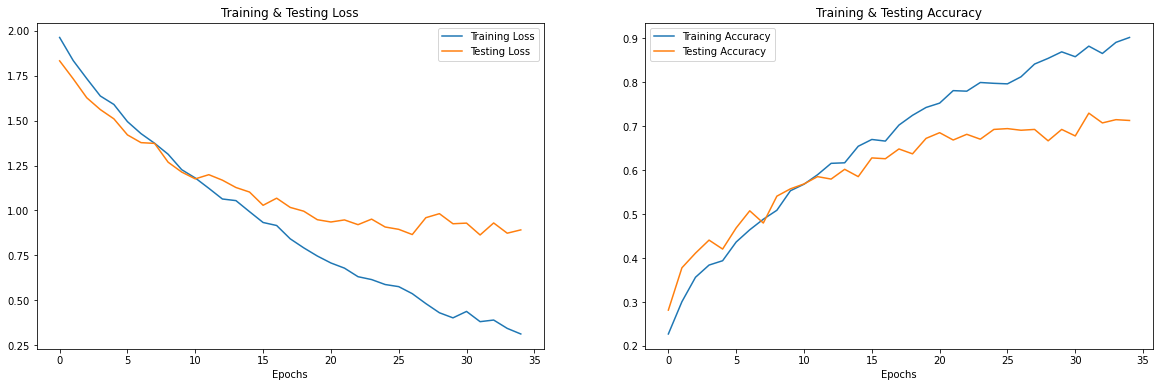

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 3s 45ms/step - loss: 1.9579 - accuracy: 0.2052 - val_loss: 1.8519 - val_accuracy: 0.3040
Epoch 2/35
49/49 [==============================] - 2s 31ms/step - loss: 1.8446 - accuracy: 0.2706 - val_loss: 1.7633 - val_accuracy: 0.3133
Epoch 3/35
49/49 [==============================] - 0s 6ms/step - loss: 1.7417 - accuracy: 0.3364 - val_loss: 1.6314 - val_accuracy: 0.3997
Epoch 4/35
49/49 [==============================] - 0s 8ms/step - loss: 1.6199 - accuracy: 0.3894 - val_loss: 1.5900 - val_accuracy: 0.3997
Epoch 5/35
49/49 [==============================] - 1s 27ms/step - loss: 1.5613 - accuracy: 0.4069 - val_loss: 1.4481 - val_accuracy: 0.4830
Epoch 6/35
49/49 [==============================] - 1s 20ms/step - loss: 1.4454 - accuracy: 0.4434 - val_loss: 1.418

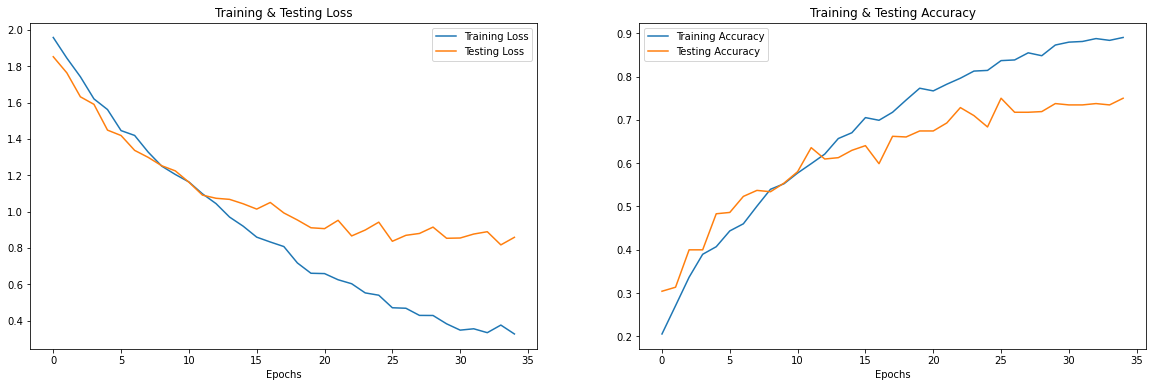

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 3s 45ms/step - loss: 1.9600 - accuracy: 0.2206 - val_loss: 1.8555 - val_accuracy: 0.3420
Epoch 2/35
61/61 [==============================] - 2s 40ms/step - loss: 1.8330 - accuracy: 0.2840 - val_loss: 1.7035 - val_accuracy: 0.3519
Epoch 3/35
61/61 [==============================] - 2s 40ms/step - loss: 1.6882 - accuracy: 0.3486 - val_loss: 1.5501 - val_accuracy: 0.4444
Epoch 4/35
61/61 [==============================] - 2s 37ms/step - loss: 1.5883 - accuracy: 0.3959 - val_loss: 1.4508 - val_accuracy: 0.4642
Epoch 5/35
61/61 [==============================] - 2s 39ms/step - loss: 1.5175 - accuracy: 0.4111 - val_loss: 1.4096 - val_accuracy: 0.4741
Epoch 6/35
61/61 [==============================] - 0s 7ms/step - loss: 1.4320 - accuracy: 0.4535 - val_loss: 1.30

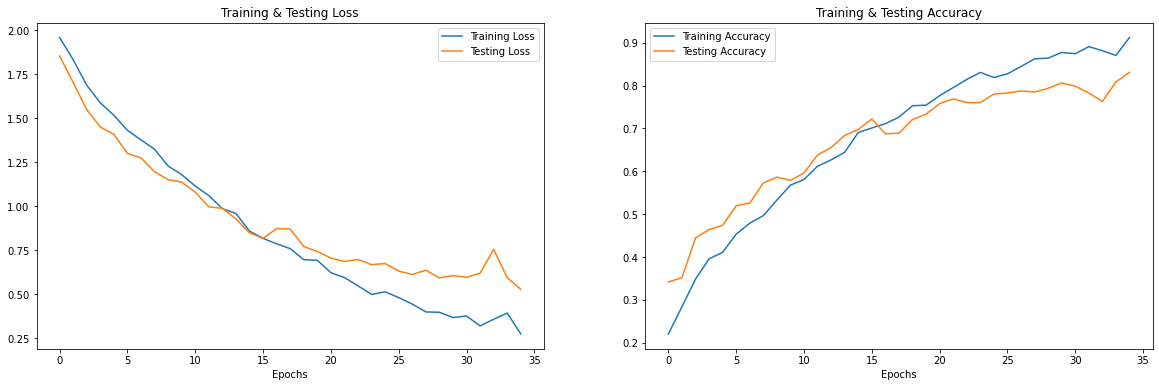

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 4s 49ms/step - loss: 1.9520 - accuracy: 0.2145 - val_loss: 1.8377 - val_accuracy: 0.3472
Epoch 2/35
65/65 [==============================] - 2s 36ms/step - loss: 1.8209 - accuracy: 0.2932 - val_loss: 1.6675 - val_accuracy: 0.3935
Epoch 3/35
65/65 [==============================] - 2s 30ms/step - loss: 1.6974 - accuracy: 0.3507 - val_loss: 1.5548 - val_accuracy: 0.4306
Epoch 4/35
65/65 [==============================] - 2s 32ms/step - loss: 1.5621 - accuracy: 0.4163 - val_loss: 1.4197 - val_accuracy: 0.4572
Epoch 5/35
65/65 [==============================] - 0s 6ms/step - loss: 1.4997 - accuracy: 0.4248 - val_loss: 1.3521 - val_accuracy: 0.4896
Epoch 6/35
65/65 [==============================] - 1s 10ms/step - loss: 1.4321 - accuracy: 0.4610 - val_loss: 1.35

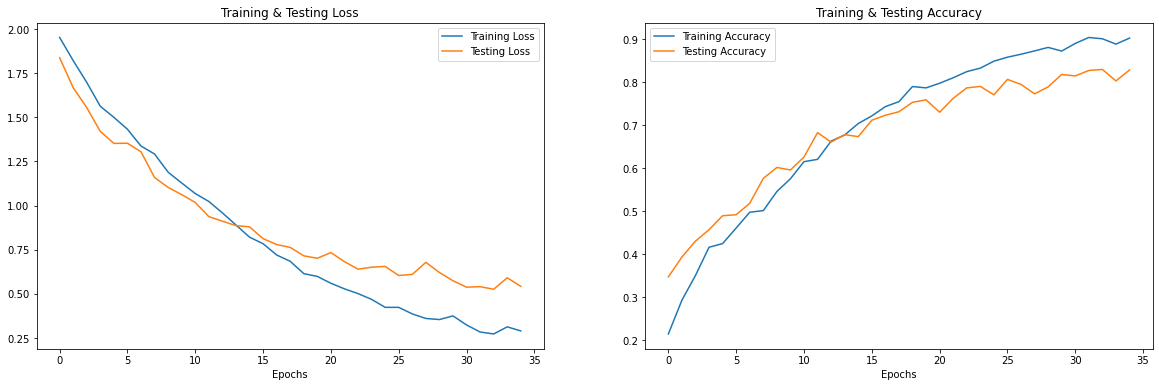

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 47ms/step - loss: 1.9715 - accuracy: 0.1994 - val_loss: 1.8870 - val_accuracy: 0.2593
Epoch 2/35
41/41 [==============================] - 1s 30ms/step - loss: 1.8591 - accuracy: 0.2840 - val_loss: 1.7622 - val_accuracy: 0.3278
Epoch 3/35
41/41 [==============================] - 2s 37ms/step - loss: 1.7388 - accuracy: 0.3222 - val_loss: 1.6576 - val_accuracy: 0.3833
Epoch 4/35
41/41 [==============================] - 2s 38ms/step - loss: 1.6331 - accuracy: 0.3753 - val_loss: 1.5666 - val_accuracy: 0.4241
Epoch 5/35
41/41 [==============================] - 2s 38ms/step - loss: 1.5806 - accuracy: 0.3883 - val_loss: 1.5229 - val_accuracy: 0.4296
Epoch 6/35
41/41 [==============================] - 2s 38ms/step - loss: 1.5163 - accuracy: 0.4056 - val_loss: 1.4

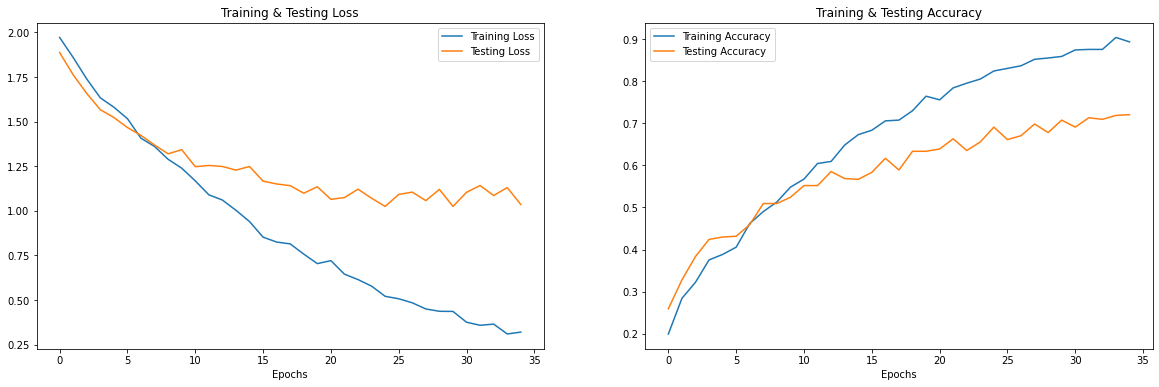

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 34ms/step - loss: 1.9759 - accuracy: 0.2022 - val_loss: 1.8500 - val_accuracy: 0.2685
Epoch 2/35
49/49 [==============================] - 2s 41ms/step - loss: 1.8572 - accuracy: 0.2793 - val_loss: 1.7438 - val_accuracy: 0.3673
Epoch 3/35
49/49 [==============================] - 2s 47ms/step - loss: 1.7411 - accuracy: 0.3261 - val_loss: 1.6413 - val_accuracy: 0.3765
Epoch 4/35
49/49 [==============================] - 1s 22ms/step - loss: 1.6548 - accuracy: 0.3760 - val_loss: 1.5069 - val_accuracy: 0.4213
Epoch 5/35
49/49 [==============================] - 2s 32ms/step - loss: 1.5322 - accuracy: 0.3997 - val_loss: 1.4836 - val_accuracy: 0.4367
Epoch 6/35
49/49 [==============================] - 1s 30ms/step - loss: 1.4480 - accuracy: 0.4475 - val_loss: 1.4

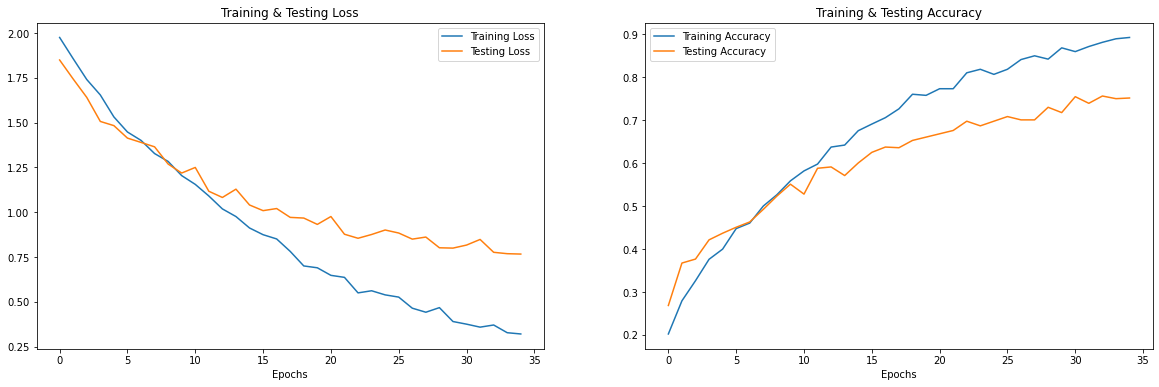

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 1s 13ms/step - loss: 1.9597 - accuracy: 0.2058 - val_loss: 1.8734 - val_accuracy: 0.2444
Epoch 2/35
61/61 [==============================] - 1s 10ms/step - loss: 1.8389 - accuracy: 0.2737 - val_loss: 1.7204 - val_accuracy: 0.3679
Epoch 3/35
61/61 [==============================] - 0s 6ms/step - loss: 1.7108 - accuracy: 0.3543 - val_loss: 1.5779 - val_accuracy: 0.4210
Epoch 4/35
61/61 [==============================] - 1s 9ms/step - loss: 1.5976 - accuracy: 0.3975 - val_loss: 1.4764 - val_accuracy: 0.4259
Epoch 5/35
61/61 [==============================] - 0s 7ms/step - loss: 1.5139 - accuracy: 0.4235 - val_loss: 1.4147 - val_accuracy: 0.4444
Epoch 6/35
61/61 [==============================] - 0s 6ms/step - loss: 1.4414 - accuracy: 0.4613 - val_loss: 1.3353 

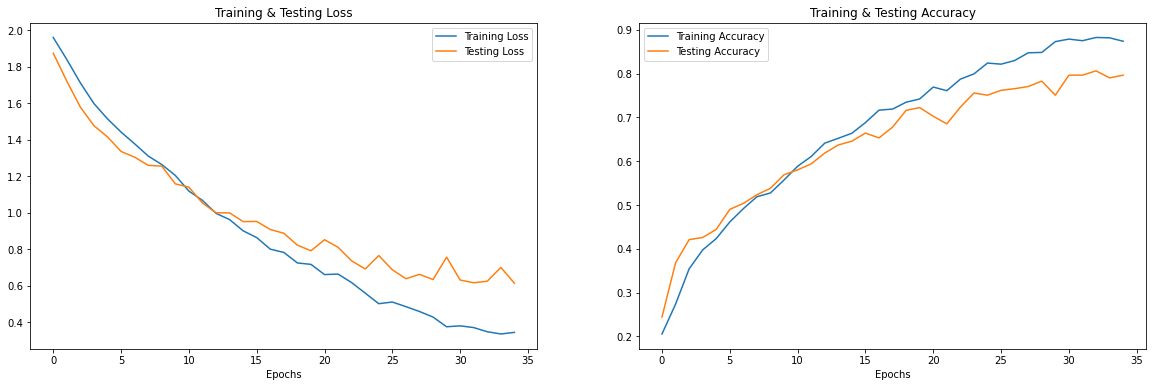

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 2s 30ms/step - loss: 1.9563 - accuracy: 0.1975 - val_loss: 1.8275 - val_accuracy: 0.3021
Epoch 2/35
65/65 [==============================] - 1s 19ms/step - loss: 1.8091 - accuracy: 0.3044 - val_loss: 1.6636 - val_accuracy: 0.3681
Epoch 3/35
65/65 [==============================] - 0s 6ms/step - loss: 1.6608 - accuracy: 0.3777 - val_loss: 1.5072 - val_accuracy: 0.4329
Epoch 4/35
65/65 [==============================] - 0s 7ms/step - loss: 1.5388 - accuracy: 0.4105 - val_loss: 1.4408 - val_accuracy: 0.4618
Epoch 5/35
65/65 [==============================] - 1s 8ms/step - loss: 1.4627 - accuracy: 0.4525 - val_loss: 1.4127 - val_accuracy: 0.4583
Epoch 6/35
65/65 [==============================] - 0s 6ms/step - loss: 1.3655 - accuracy: 0.5015 - val_loss: 1.2649 

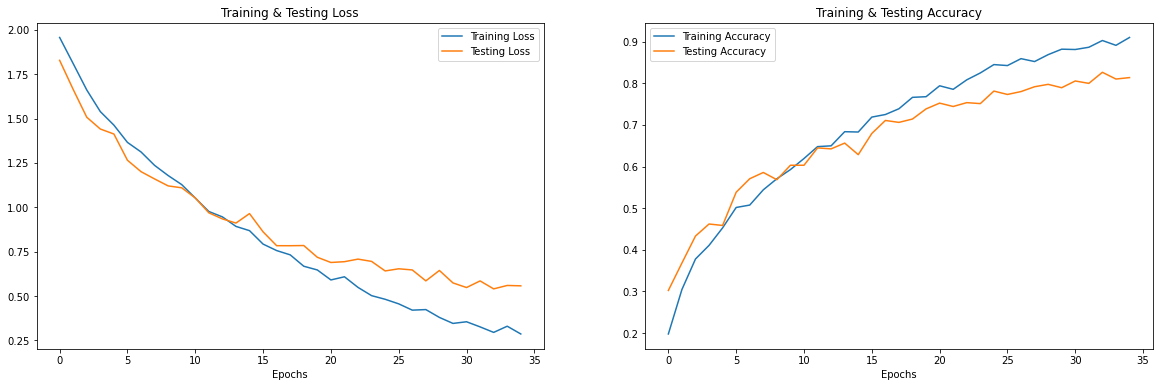

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 30ms/step - loss: 1.9583 - accuracy: 0.2167 - val_loss: 1.9361 - val_accuracy: 0.3167
Epoch 2/35
41/41 [==============================] - 2s 41ms/step - loss: 1.8719 - accuracy: 0.2741 - val_loss: 1.7536 - val_accuracy: 0.3500
Epoch 3/35
41/41 [==============================] - 2s 40ms/step - loss: 1.7947 - accuracy: 0.3093 - val_loss: 1.6647 - val_accuracy: 0.3722
Epoch 4/35
41/41 [==============================] - 1s 33ms/step - loss: 1.6793 - accuracy: 0.3716 - val_loss: 1.5646 - val_accuracy: 0.4167
Epoch 5/35
41/41 [==============================] - 1s 22ms/step - loss: 1.6109 - accuracy: 0.3877 - val_loss: 1.5082 - val_accuracy: 0.4241
Epoch 6/35
41/41 [==============================] - 0s 6ms/step - loss: 1.5358 - accuracy: 0.4278 - val_loss: 1.43

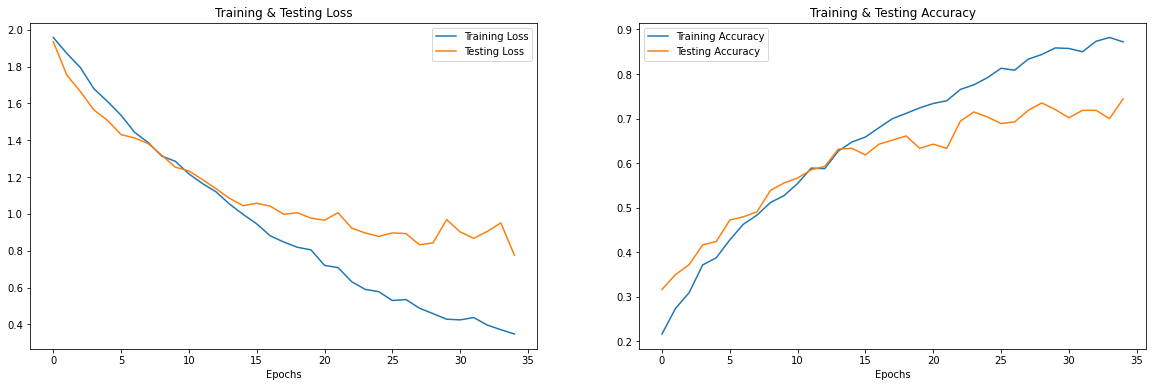

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 1s 12ms/step - loss: 1.9677 - accuracy: 0.2155 - val_loss: 1.8586 - val_accuracy: 0.2546
Epoch 2/35
49/49 [==============================] - 2s 32ms/step - loss: 1.8510 - accuracy: 0.2917 - val_loss: 1.7230 - val_accuracy: 0.3627
Epoch 3/35
49/49 [==============================] - 2s 36ms/step - loss: 1.7370 - accuracy: 0.3673 - val_loss: 1.6090 - val_accuracy: 0.4228
Epoch 4/35
49/49 [==============================] - 1s 22ms/step - loss: 1.6376 - accuracy: 0.3873 - val_loss: 1.5626 - val_accuracy: 0.4012
Epoch 5/35
49/49 [==============================] - 0s 6ms/step - loss: 1.5839 - accuracy: 0.4033 - val_loss: 1.4577 - val_accuracy: 0.4784
Epoch 6/35
49/49 [==============================] - 0s 6ms/step - loss: 1.4810 - accuracy: 0.4537 - val_loss: 1.414

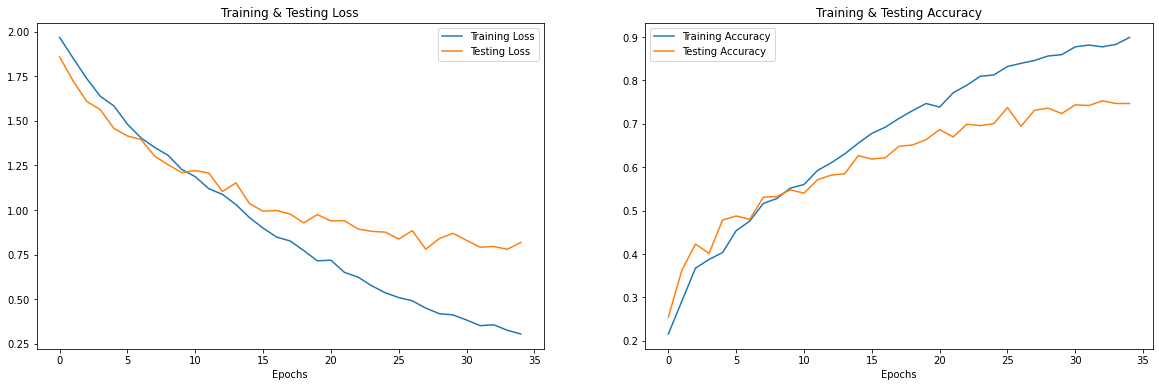

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 3s 38ms/step - loss: 1.9543 - accuracy: 0.2156 - val_loss: 1.8335 - val_accuracy: 0.2975
Epoch 2/35
61/61 [==============================] - 2s 37ms/step - loss: 1.8032 - accuracy: 0.3099 - val_loss: 1.6701 - val_accuracy: 0.3630
Epoch 3/35
61/61 [==============================] - 2s 38ms/step - loss: 1.6437 - accuracy: 0.3786 - val_loss: 1.5712 - val_accuracy: 0.4062
Epoch 4/35
61/61 [==============================] - 2s 40ms/step - loss: 1.5373 - accuracy: 0.4165 - val_loss: 1.4898 - val_accuracy: 0.4494
Epoch 5/35
61/61 [==============================] - 2s 26ms/step - loss: 1.4493 - accuracy: 0.4494 - val_loss: 1.4018 - val_accuracy: 0.4914
Epoch 6/35
61/61 [==============================] - 0s 5ms/step - loss: 1.3903 - accuracy: 0.4786 - val_loss: 1.35

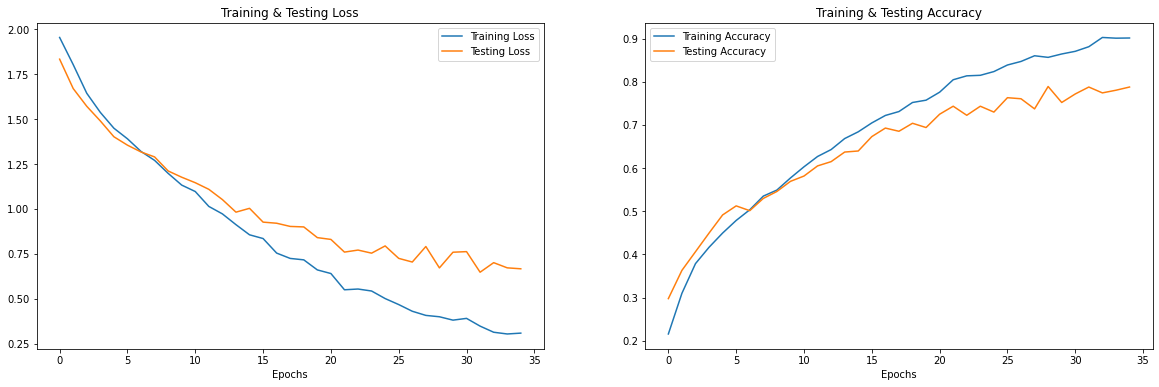

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 1s 11ms/step - loss: 1.9266 - accuracy: 0.2342 - val_loss: 1.7927 - val_accuracy: 0.3576
Epoch 2/35
65/65 [==============================] - 2s 37ms/step - loss: 1.7528 - accuracy: 0.3256 - val_loss: 1.6265 - val_accuracy: 0.3981
Epoch 3/35
65/65 [==============================] - 2s 38ms/step - loss: 1.6168 - accuracy: 0.3839 - val_loss: 1.5258 - val_accuracy: 0.4282
Epoch 4/35
65/65 [==============================] - 1s 21ms/step - loss: 1.5194 - accuracy: 0.4279 - val_loss: 1.4352 - val_accuracy: 0.4618
Epoch 5/35
65/65 [==============================] - 1s 14ms/step - loss: 1.4249 - accuracy: 0.4707 - val_loss: 1.3727 - val_accuracy: 0.4769
Epoch 6/35
65/65 [==============================] - 0s 5ms/step - loss: 1.3511 - accuracy: 0.5062 - val_loss: 1.28

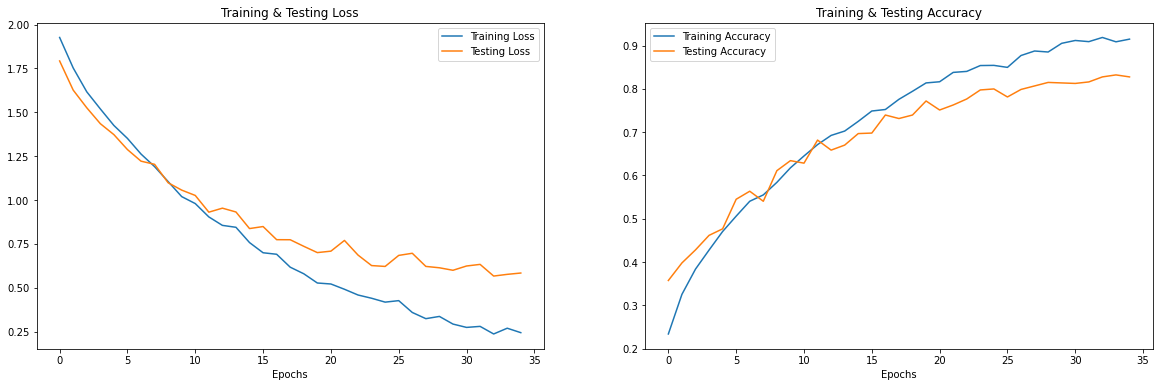

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 34ms/step - loss: 1.9731 - accuracy: 0.1988 - val_loss: 1.8619 - val_accuracy: 0.2407
Epoch 2/35
41/41 [==============================] - 0s 6ms/step - loss: 1.8490 - accuracy: 0.2778 - val_loss: 1.7549 - val_accuracy: 0.3259
Epoch 3/35
41/41 [==============================] - 0s 6ms/step - loss: 1.7339 - accuracy: 0.3383 - val_loss: 1.6388 - val_accuracy: 0.3685
Epoch 4/35
41/41 [==============================] - 0s 7ms/step - loss: 1.6508 - accuracy: 0.3698 - val_loss: 1.5653 - val_accuracy: 0.3833
Epoch 5/35
41/41 [==============================] - 0s 8ms/step - loss: 1.5594 - accuracy: 0.4006 - val_loss: 1.5428 - val_accuracy: 0.4315
Epoch 6/35
41/41 [==============================] - 1s 13ms/step - loss: 1.4934 - accuracy: 0.4438 - val_loss: 1.4897 

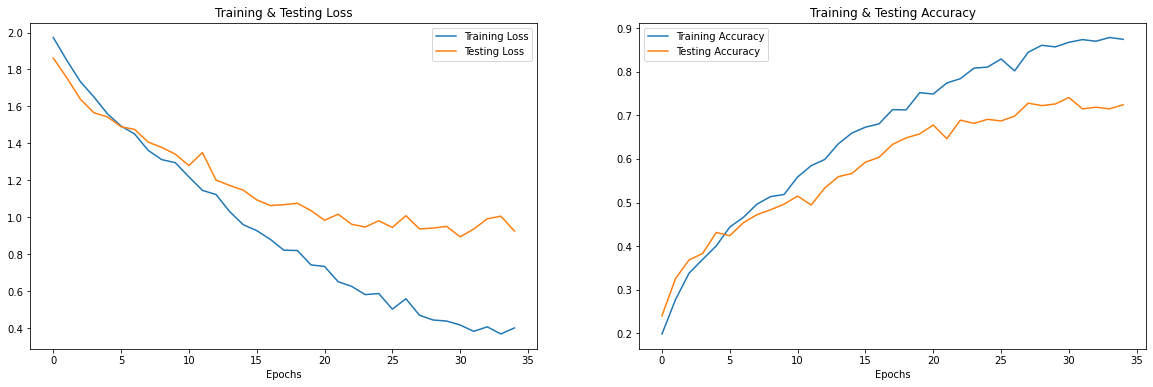

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 1s 19ms/step - loss: 1.9726 - accuracy: 0.2088 - val_loss: 1.8636 - val_accuracy: 0.2392
Epoch 2/35
49/49 [==============================] - 2s 32ms/step - loss: 1.8571 - accuracy: 0.2773 - val_loss: 1.7190 - val_accuracy: 0.3503
Epoch 3/35
49/49 [==============================] - 2s 37ms/step - loss: 1.7334 - accuracy: 0.3153 - val_loss: 1.6735 - val_accuracy: 0.3688
Epoch 4/35
49/49 [==============================] - 2s 37ms/step - loss: 1.6670 - accuracy: 0.3714 - val_loss: 1.5358 - val_accuracy: 0.4028
Epoch 5/35
49/49 [==============================] - 2s 41ms/step - loss: 1.5501 - accuracy: 0.4120 - val_loss: 1.4960 - val_accuracy: 0.4228
Epoch 6/35
49/49 [==============================] - 2s 40ms/step - loss: 1.4801 - accuracy: 0.4429 - val_loss: 1.3

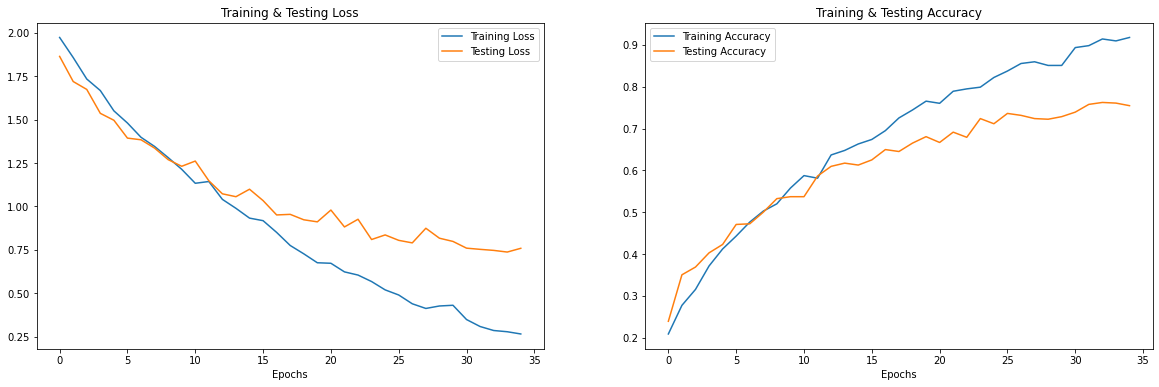

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 1s 13ms/step - loss: 1.9492 - accuracy: 0.2255 - val_loss: 1.8376 - val_accuracy: 0.2864
Epoch 2/35
61/61 [==============================] - 1s 17ms/step - loss: 1.8048 - accuracy: 0.3049 - val_loss: 1.6848 - val_accuracy: 0.3840
Epoch 3/35
61/61 [==============================] - 1s 14ms/step - loss: 1.6431 - accuracy: 0.3770 - val_loss: 1.5728 - val_accuracy: 0.3963
Epoch 4/35
61/61 [==============================] - 0s 6ms/step - loss: 1.5442 - accuracy: 0.4198 - val_loss: 1.4851 - val_accuracy: 0.4358
Epoch 5/35
61/61 [==============================] - 0s 6ms/step - loss: 1.4756 - accuracy: 0.4424 - val_loss: 1.4258 - val_accuracy: 0.4481
Epoch 6/35
61/61 [==============================] - 0s 7ms/step - loss: 1.3747 - accuracy: 0.4770 - val_loss: 1.3826

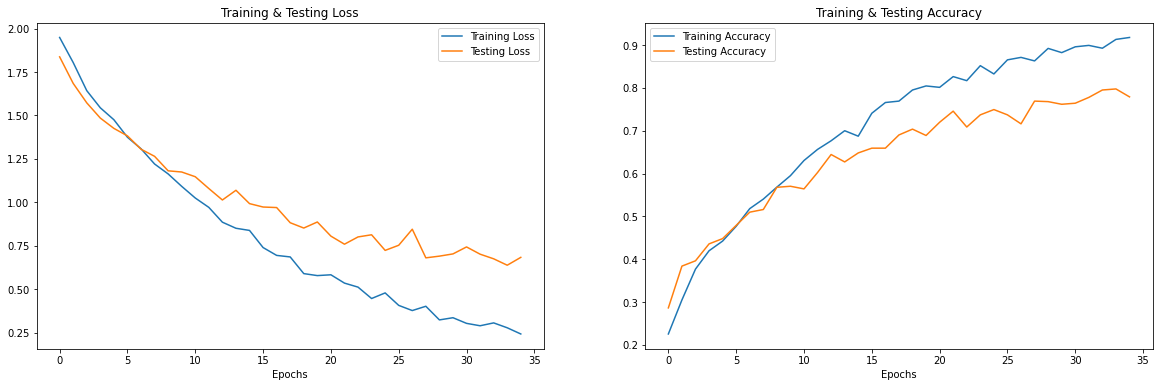

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 3s 38ms/step - loss: 1.9423 - accuracy: 0.2261 - val_loss: 1.8434 - val_accuracy: 0.3368
Epoch 2/35
65/65 [==============================] - 1s 15ms/step - loss: 1.7666 - accuracy: 0.3245 - val_loss: 1.6367 - val_accuracy: 0.3808
Epoch 3/35
65/65 [==============================] - 3s 40ms/step - loss: 1.6253 - accuracy: 0.3677 - val_loss: 1.5734 - val_accuracy: 0.4016
Epoch 4/35
65/65 [==============================] - 0s 5ms/step - loss: 1.5306 - accuracy: 0.4194 - val_loss: 1.4765 - val_accuracy: 0.4456
Epoch 5/35
65/65 [==============================] - 0s 6ms/step - loss: 1.4452 - accuracy: 0.4417 - val_loss: 1.3907 - val_accuracy: 0.4676
Epoch 6/35
65/65 [==============================] - 0s 6ms/step - loss: 1.3607 - accuracy: 0.4900 - val_loss: 1.3697

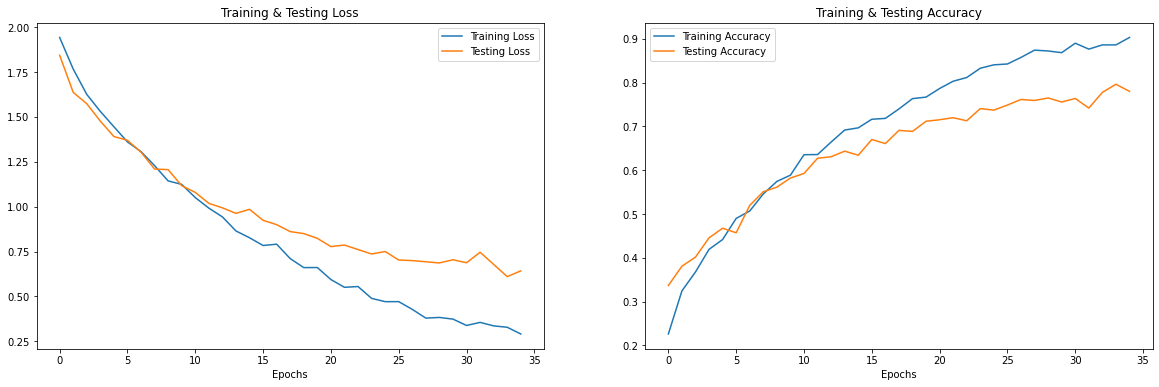

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 37ms/step - loss: 1.9903 - accuracy: 0.1944 - val_loss: 1.9212 - val_accuracy: 0.2667
Epoch 2/35
41/41 [==============================] - 1s 19ms/step - loss: 1.8760 - accuracy: 0.2426 - val_loss: 1.8389 - val_accuracy: 0.3500
Epoch 3/35
41/41 [==============================] - 0s 6ms/step - loss: 1.7944 - accuracy: 0.3012 - val_loss: 1.7021 - val_accuracy: 0.3426
Epoch 4/35
41/41 [==============================] - 0s 6ms/step - loss: 1.6680 - accuracy: 0.3586 - val_loss: 1.6199 - val_accuracy: 0.3796
Epoch 5/35
41/41 [==============================] - 0s 8ms/step - loss: 1.5675 - accuracy: 0.3864 - val_loss: 1.5190 - val_accuracy: 0.4389
Epoch 6/35
41/41 [==============================] - 0s 7ms/step - loss: 1.5041 - accuracy: 0.4191 - val_loss: 1.4456 

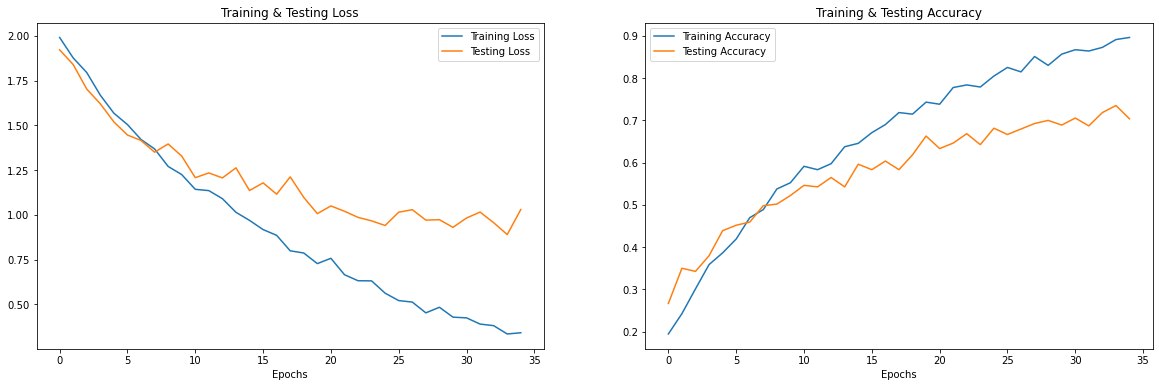

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 30ms/step - loss: 1.9712 - accuracy: 0.2068 - val_loss: 1.8188 - val_accuracy: 0.3364
Epoch 2/35
49/49 [==============================] - 0s 8ms/step - loss: 1.8175 - accuracy: 0.3076 - val_loss: 1.6528 - val_accuracy: 0.3673
Epoch 3/35
49/49 [==============================] - 2s 37ms/step - loss: 1.6869 - accuracy: 0.3565 - val_loss: 1.5658 - val_accuracy: 0.4028
Epoch 4/35
49/49 [==============================] - 2s 34ms/step - loss: 1.5991 - accuracy: 0.3853 - val_loss: 1.4889 - val_accuracy: 0.4645
Epoch 5/35
49/49 [==============================] - 2s 38ms/step - loss: 1.5048 - accuracy: 0.4326 - val_loss: 1.4925 - val_accuracy: 0.4352
Epoch 6/35
49/49 [==============================] - 2s 34ms/step - loss: 1.4527 - accuracy: 0.4470 - val_loss: 1.35

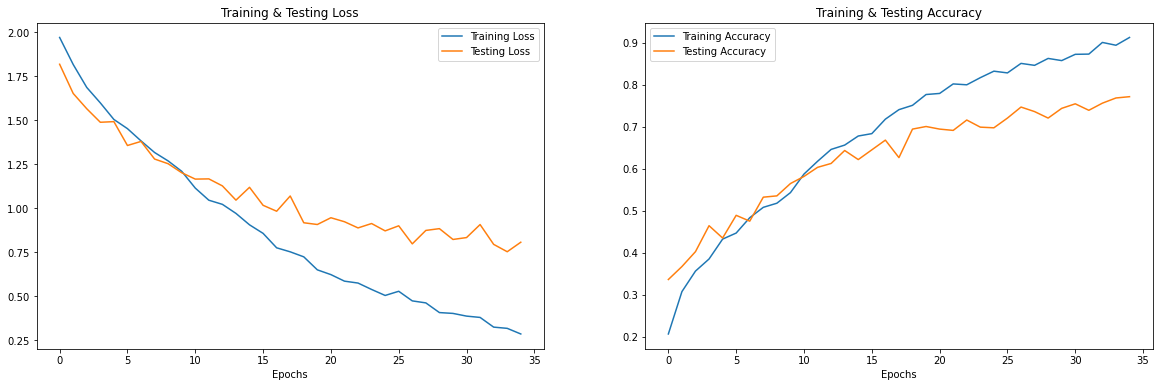

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 1s 12ms/step - loss: 1.9535 - accuracy: 0.2350 - val_loss: 1.8248 - val_accuracy: 0.3259
Epoch 2/35
61/61 [==============================] - 2s 36ms/step - loss: 1.7949 - accuracy: 0.3099 - val_loss: 1.6600 - val_accuracy: 0.4062
Epoch 3/35
61/61 [==============================] - 2s 28ms/step - loss: 1.6707 - accuracy: 0.3638 - val_loss: 1.5879 - val_accuracy: 0.3790
Epoch 4/35
61/61 [==============================] - 0s 6ms/step - loss: 1.5948 - accuracy: 0.3864 - val_loss: 1.4759 - val_accuracy: 0.4765
Epoch 5/35
61/61 [==============================] - 0s 6ms/step - loss: 1.5070 - accuracy: 0.4247 - val_loss: 1.4228 - val_accuracy: 0.4840
Epoch 6/35
61/61 [==============================] - 0s 6ms/step - loss: 1.4355 - accuracy: 0.4642 - val_loss: 1.3366

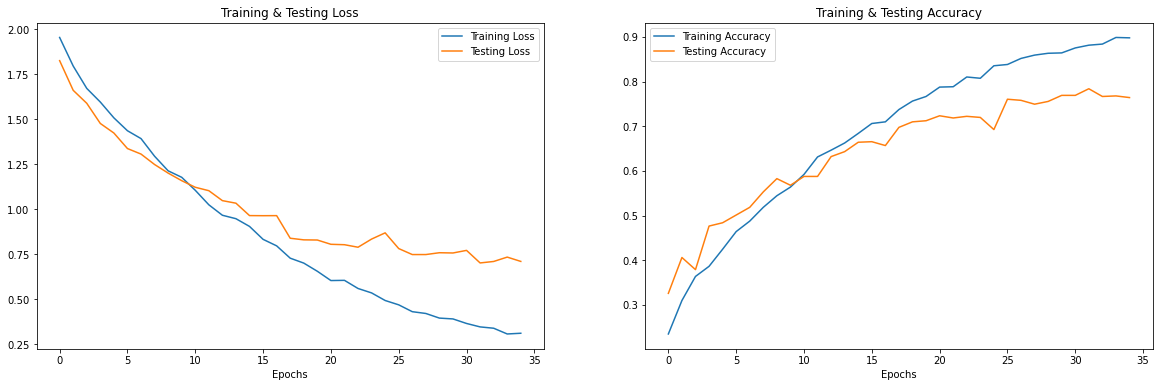

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 3s 38ms/step - loss: 1.9279 - accuracy: 0.2396 - val_loss: 1.7860 - val_accuracy: 0.3530
Epoch 2/35
65/65 [==============================] - 0s 6ms/step - loss: 1.7434 - accuracy: 0.3360 - val_loss: 1.6021 - val_accuracy: 0.4062
Epoch 3/35
65/65 [==============================] - 0s 6ms/step - loss: 1.6268 - accuracy: 0.3684 - val_loss: 1.5390 - val_accuracy: 0.4294
Epoch 4/35
65/65 [==============================] - 1s 22ms/step - loss: 1.5211 - accuracy: 0.4225 - val_loss: 1.4794 - val_accuracy: 0.4306
Epoch 5/35
65/65 [==============================] - 1s 19ms/step - loss: 1.4426 - accuracy: 0.4541 - val_loss: 1.4008 - val_accuracy: 0.4664
Epoch 6/35
65/65 [==============================] - 1s 18ms/step - loss: 1.3976 - accuracy: 0.4892 - val_loss: 1.368

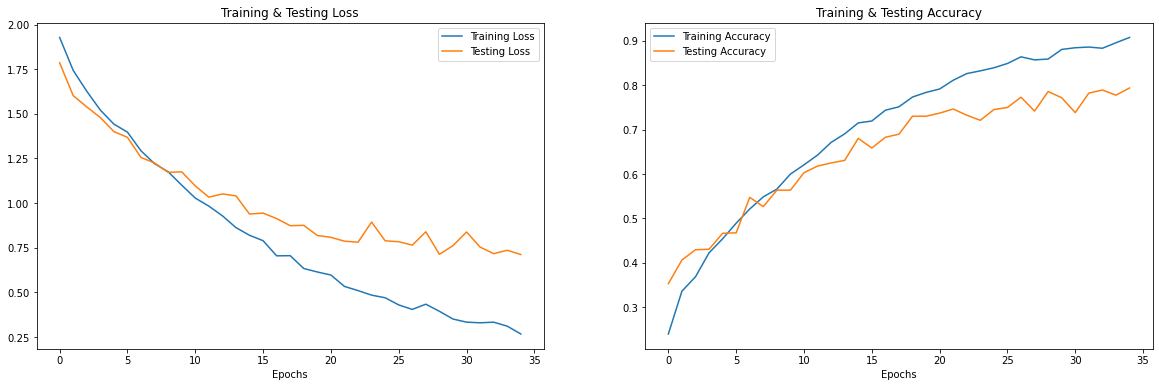

In [76]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_train_test_xy(),total=5):
    Model_2_dict = {}
    Histories_2 = {}
    for k in cg:
        Model_2_dict[k] = model_2(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 2")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Histories_2[k] = Model_2_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    # verbose=0,
                                    callbacks=[rlrp])
        
        
        print("-------------------")
        print(f"Traing is done for Model 2")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        
        model_2_acc_matrix[k].append(loss_accuracy_details(Model_2_dict[k],
                                                           Histories_2[k],
                                                           epoch,x_tests[k],
                                                           y_tests[k]
                                                           ))
        
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_2',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'model_2',k))
        Model_2_dict[k].save(os.path.join("Models",'model_2',k,f"model_2_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [77]:
model_2_acc_Df = pd.DataFrame(model_2_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
model_2_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'model_2_acc_mat.csv'))
model_2_acc_Df.head()

,10,13,17,24,51
a,70.694447,70.879632,72.824073,68.194443,71.203703
b,74.363428,74.594909,75.578701,75.694442,75.636572
c,79.907405,77.222222,76.944447,77.314812,77.037036
d,78.587961,77.662039,78.240740,79.513890,79.976851


In [78]:
model_2_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,70.759259,75.173610,77.685184,78.796296
std,1.662675,0.640505,1.250856,0.941705
min,68.194443,74.363428,76.944447,77.662039
25%,70.694447,74.594909,77.037036,78.240740
50%,70.879632,75.578701,77.222222,78.587961
75%,71.203703,75.636572,77.314812,79.513890
max,72.824073,75.694442,79.907405,79.976851


---
# Model 3 Training Testing
---

In [81]:
def model_3(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 3, padding = 'same'))

    model.add(Conv1D(256, kernel_size=9, strides=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 5, padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model


In [82]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_3')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_3'))

In [83]:
model_3_acc_matrix = {}
for k in cg:
   model_3_acc_matrix[k]= list()
print(model_3_acc_matrix) 

{'a': [], 'b': [], 'c': [], 'd': []}


  0%|          | 0/5 [00:00<?, ?it/s]

Random State : = 10
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 27ms/step - loss: 1.9330 - accuracy: 0.2327 - val_loss: 1.7902 - val_accuracy: 0.3389
Epoch 2/35
41/41 [==============================] - 1s 21ms/step - loss: 1.7889 - accuracy: 0.3241 - val_loss: 1.6470 - val_accuracy: 0.3981
Epoch 3/35
41/41 [==============================] - 1s 21ms/step - loss: 1.6627 - accuracy: 0.3809 - val_loss: 1.5110 - val_accuracy: 0.4278
Epoch 4/35
41/41 [==============================] - 1s 23ms/step - loss: 1.5639 - accuracy: 0.4265 - val_loss: 1.5192 - val_accuracy: 0.4370
Epoch 5/35
41/41 [==============================] - 1s 22ms/step - loss: 1.4803 - accuracy: 0.4512 - val_loss: 1.4082 - val_accuracy: 0.4704
Epoch 6/35
41/41 [==============================] - 1s 24ms/step - loss: 1.3915 - accuracy: 0.4846 - val_loss: 1.3

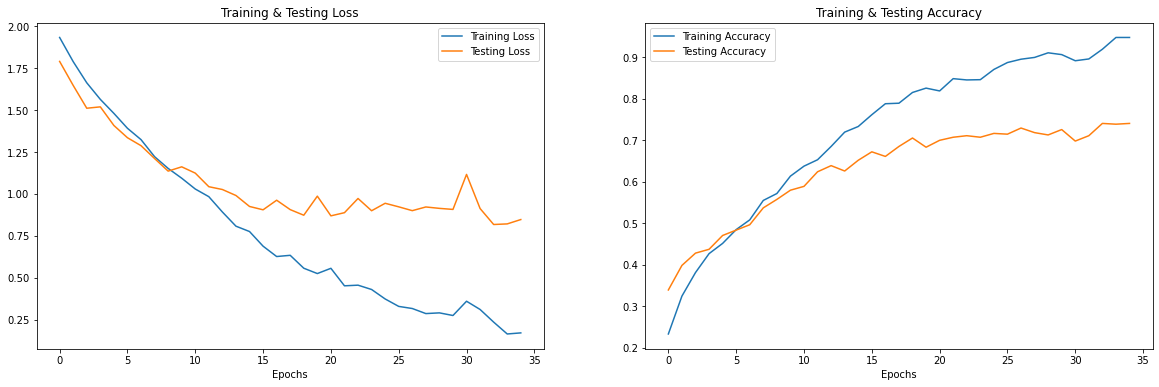

Random State : = 10
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 4s 71ms/step - loss: 1.9123 - accuracy: 0.2433 - val_loss: 1.7344 - val_accuracy: 0.3302
Epoch 2/35
49/49 [==============================] - 2s 40ms/step - loss: 1.7312 - accuracy: 0.3519 - val_loss: 1.5712 - val_accuracy: 0.3920
Epoch 3/35
49/49 [==============================] - 1s 27ms/step - loss: 1.5865 - accuracy: 0.4012 - val_loss: 1.5204 - val_accuracy: 0.4398
Epoch 4/35
49/49 [==============================] - 1s 25ms/step - loss: 1.5142 - accuracy: 0.4393 - val_loss: 1.3939 - val_accuracy: 0.4738
Epoch 5/35
49/49 [==============================] - 1s 24ms/step - loss: 1.4239 - accuracy: 0.4655 - val_loss: 1.3420 - val_accuracy: 0.5031
Epoch 6/35
49/49 [==============================] - 1s 23ms/step - loss: 1.3501 - accuracy: 0.4856 - val_loss: 1.2

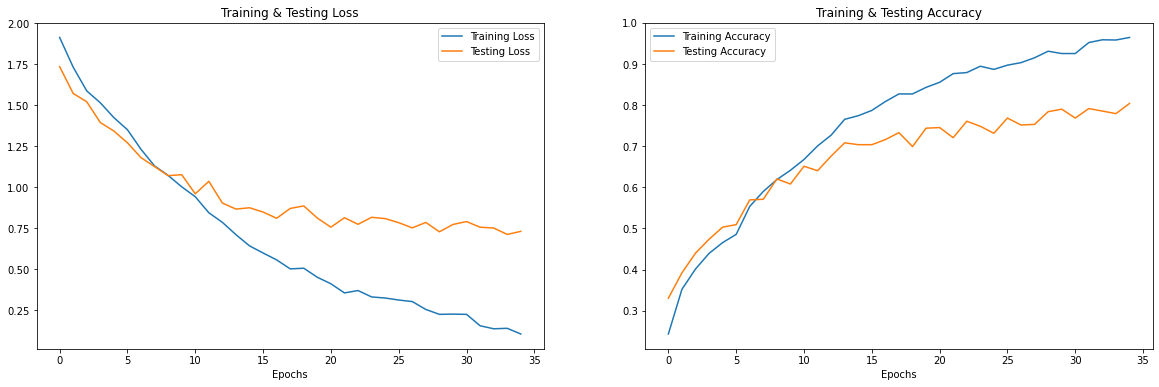

Random State : = 10
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 4s 58ms/step - loss: 1.9026 - accuracy: 0.2539 - val_loss: 1.7067 - val_accuracy: 0.3728
Epoch 2/35
61/61 [==============================] - 3s 46ms/step - loss: 1.6742 - accuracy: 0.3564 - val_loss: 1.5519 - val_accuracy: 0.4432
Epoch 3/35
61/61 [==============================] - 2s 25ms/step - loss: 1.5605 - accuracy: 0.4091 - val_loss: 1.5079 - val_accuracy: 0.4086
Epoch 4/35
61/61 [==============================] - 2s 27ms/step - loss: 1.4408 - accuracy: 0.4551 - val_loss: 1.4140 - val_accuracy: 0.4938
Epoch 5/35
61/61 [==============================] - 1s 23ms/step - loss: 1.3407 - accuracy: 0.4975 - val_loss: 1.2598 - val_accuracy: 0.5111
Epoch 6/35
61/61 [==============================] - 2s 27ms/step - loss: 1.2590 - accuracy: 0.5354 - val_loss: 1.2

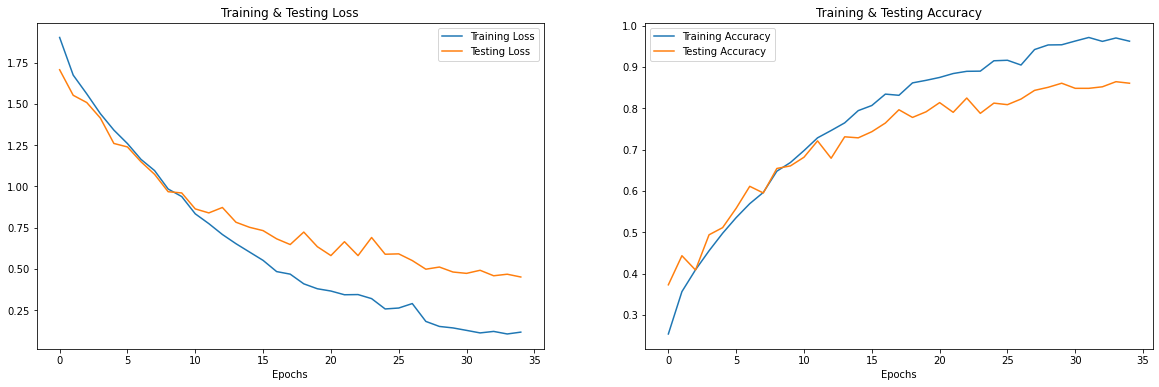

Random State : = 10
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 5s 67ms/step - loss: 1.9063 - accuracy: 0.2461 - val_loss: 1.7151 - val_accuracy: 0.3738
Epoch 2/35
65/65 [==============================] - 2s 33ms/step - loss: 1.6937 - accuracy: 0.3650 - val_loss: 1.5277 - val_accuracy: 0.4259
Epoch 3/35
65/65 [==============================] - 2s 25ms/step - loss: 1.5481 - accuracy: 0.4093 - val_loss: 1.4293 - val_accuracy: 0.4664
Epoch 4/35
65/65 [==============================] - 2s 25ms/step - loss: 1.4396 - accuracy: 0.4564 - val_loss: 1.3001 - val_accuracy: 0.5278
Epoch 5/35
65/65 [==============================] - 2s 25ms/step - loss: 1.3361 - accuracy: 0.5112 - val_loss: 1.2148 - val_accuracy: 0.5671
Epoch 6/35
65/65 [==============================] - 2s 25ms/step - loss: 1.2465 - accuracy: 0.5355 - val_loss: 1.1

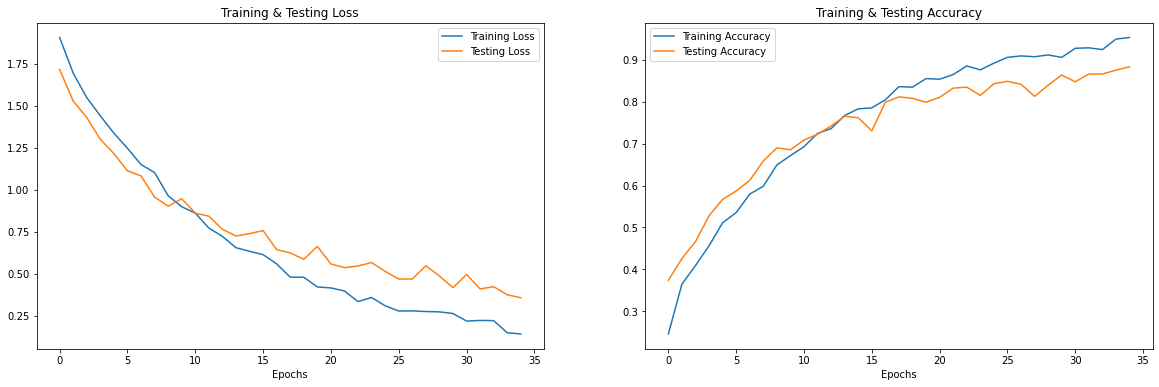

Random State : = 13
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 3s 59ms/step - loss: 1.9451 - accuracy: 0.2370 - val_loss: 1.8429 - val_accuracy: 0.3241
Epoch 2/35
41/41 [==============================] - 2s 48ms/step - loss: 1.7742 - accuracy: 0.3160 - val_loss: 1.6758 - val_accuracy: 0.3796
Epoch 3/35
41/41 [==============================] - 1s 28ms/step - loss: 1.6441 - accuracy: 0.3747 - val_loss: 1.5495 - val_accuracy: 0.4444
Epoch 4/35
41/41 [==============================] - 1s 24ms/step - loss: 1.5288 - accuracy: 0.4179 - val_loss: 1.5471 - val_accuracy: 0.4222
Epoch 5/35
41/41 [==============================] - 1s 25ms/step - loss: 1.4912 - accuracy: 0.4315 - val_loss: 1.4988 - val_accuracy: 0.4815
Epoch 6/35
41/41 [==============================] - 1s 25ms/step - loss: 1.3995 - accuracy: 0.4722 - val_loss: 1.3

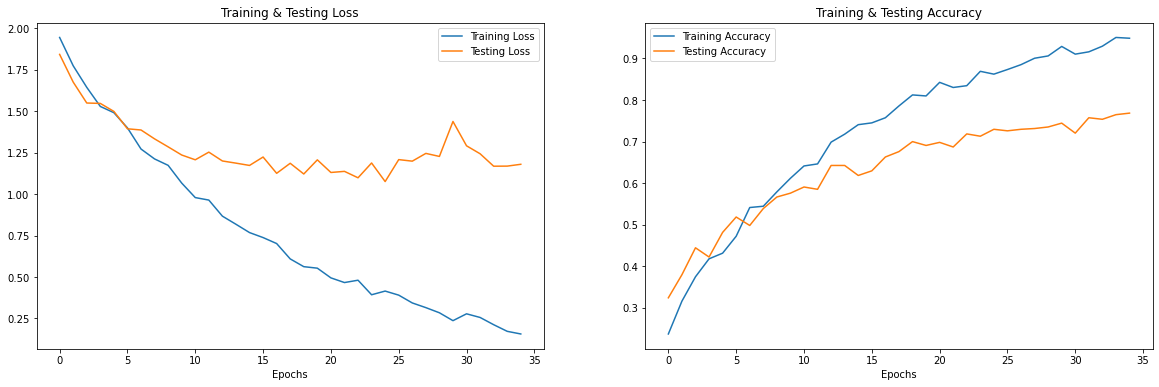

Random State : = 13
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 34ms/step - loss: 1.9221 - accuracy: 0.2366 - val_loss: 1.7391 - val_accuracy: 0.3873
Epoch 2/35
49/49 [==============================] - 1s 26ms/step - loss: 1.7380 - accuracy: 0.3390 - val_loss: 1.5708 - val_accuracy: 0.4630
Epoch 3/35
49/49 [==============================] - 1s 27ms/step - loss: 1.5983 - accuracy: 0.3879 - val_loss: 1.4471 - val_accuracy: 0.4383
Epoch 4/35
49/49 [==============================] - 1s 25ms/step - loss: 1.4967 - accuracy: 0.4414 - val_loss: 1.3709 - val_accuracy: 0.4923
Epoch 5/35
49/49 [==============================] - 1s 25ms/step - loss: 1.3988 - accuracy: 0.4650 - val_loss: 1.3152 - val_accuracy: 0.5108
Epoch 6/35
49/49 [==============================] - 1s 24ms/step - loss: 1.3539 - accuracy: 0.4907 - val_loss: 1.3

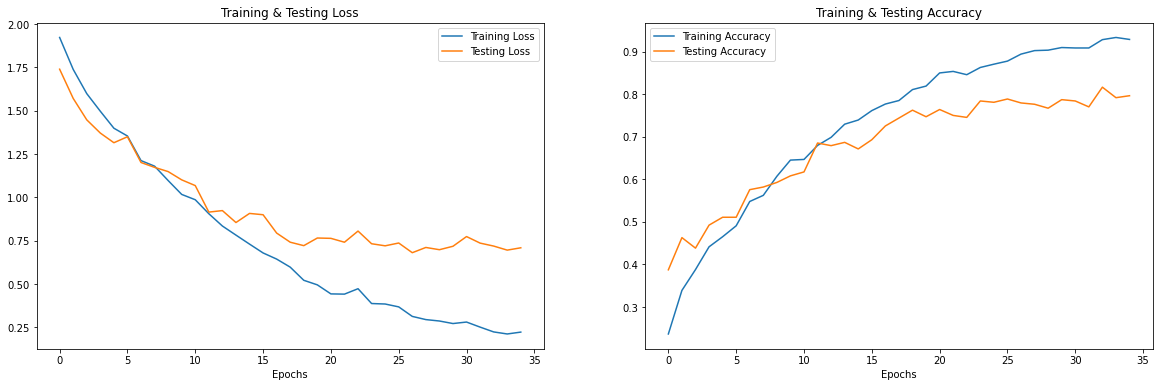

Random State : = 13
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 32ms/step - loss: 1.8946 - accuracy: 0.2551 - val_loss: 1.6836 - val_accuracy: 0.3852
Epoch 2/35
61/61 [==============================] - 2s 26ms/step - loss: 1.6907 - accuracy: 0.3704 - val_loss: 1.5235 - val_accuracy: 0.4296
Epoch 3/35
61/61 [==============================] - 2s 29ms/step - loss: 1.5549 - accuracy: 0.4037 - val_loss: 1.4216 - val_accuracy: 0.4444
Epoch 4/35
61/61 [==============================] - 2s 29ms/step - loss: 1.4502 - accuracy: 0.4621 - val_loss: 1.3854 - val_accuracy: 0.4877
Epoch 5/35
61/61 [==============================] - 2s 26ms/step - loss: 1.3722 - accuracy: 0.4790 - val_loss: 1.3387 - val_accuracy: 0.5235
Epoch 6/35
61/61 [==============================] - 2s 25ms/step - loss: 1.2980 - accuracy: 0.5206 - val_loss: 1.1

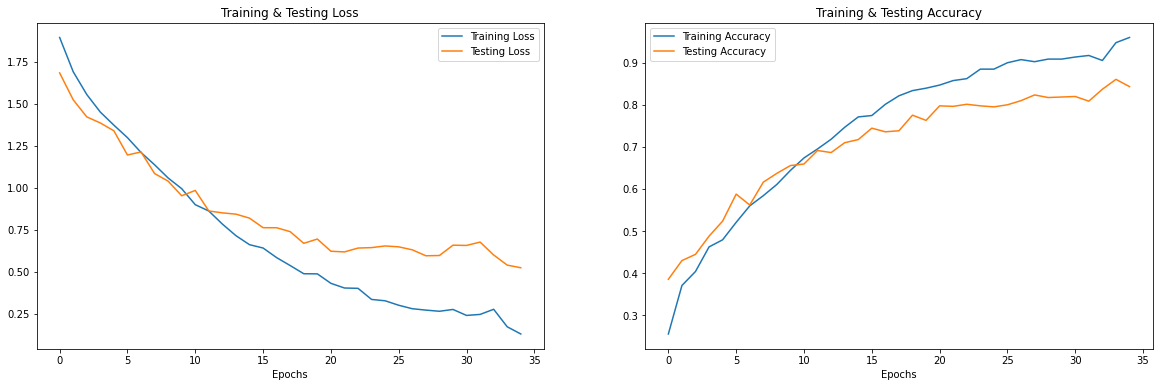

Random State : = 13
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 3s 36ms/step - loss: 1.8855 - accuracy: 0.2596 - val_loss: 1.6660 - val_accuracy: 0.3970
Epoch 2/35
65/65 [==============================] - 2s 27ms/step - loss: 1.6594 - accuracy: 0.3627 - val_loss: 1.5459 - val_accuracy: 0.3981
Epoch 3/35
65/65 [==============================] - 2s 25ms/step - loss: 1.5378 - accuracy: 0.4225 - val_loss: 1.3818 - val_accuracy: 0.5069
Epoch 4/35
65/65 [==============================] - 2s 23ms/step - loss: 1.4249 - accuracy: 0.4587 - val_loss: 1.2668 - val_accuracy: 0.5532
Epoch 5/35
65/65 [==============================] - 2s 25ms/step - loss: 1.3123 - accuracy: 0.5066 - val_loss: 1.1773 - val_accuracy: 0.5718
Epoch 6/35
65/65 [==============================] - 2s 24ms/step - loss: 1.2284 - accuracy: 0.5509 - val_loss: 1.1

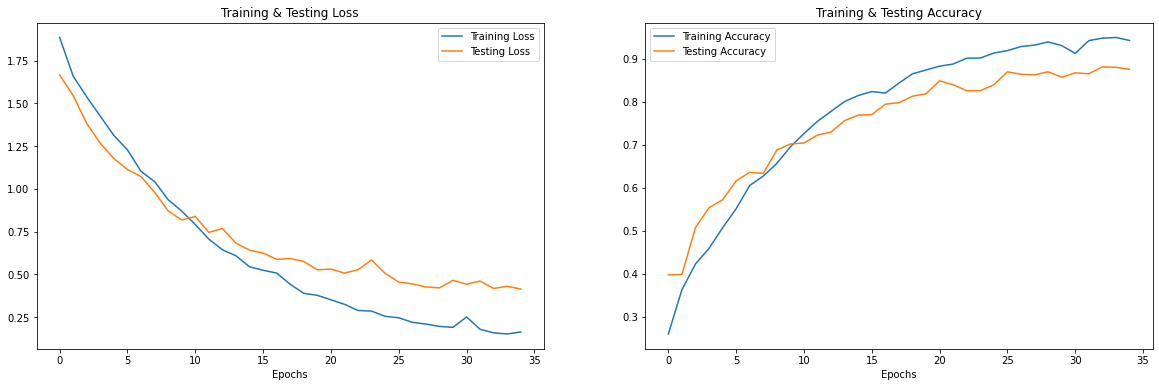

Random State : = 17
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 34ms/step - loss: 1.9433 - accuracy: 0.2210 - val_loss: 1.8491 - val_accuracy: 0.3204
Epoch 2/35
41/41 [==============================] - 1s 23ms/step - loss: 1.7896 - accuracy: 0.3117 - val_loss: 1.6846 - val_accuracy: 0.3889
Epoch 3/35
41/41 [==============================] - 1s 24ms/step - loss: 1.6724 - accuracy: 0.3574 - val_loss: 1.6102 - val_accuracy: 0.4019
Epoch 4/35
41/41 [==============================] - 1s 25ms/step - loss: 1.5578 - accuracy: 0.4210 - val_loss: 1.5184 - val_accuracy: 0.4685
Epoch 5/35
41/41 [==============================] - 1s 26ms/step - loss: 1.4683 - accuracy: 0.4463 - val_loss: 1.4410 - val_accuracy: 0.5019
Epoch 6/35
41/41 [==============================] - 1s 26ms/step - loss: 1.4073 - accuracy: 0.4741 - val_loss: 1.3

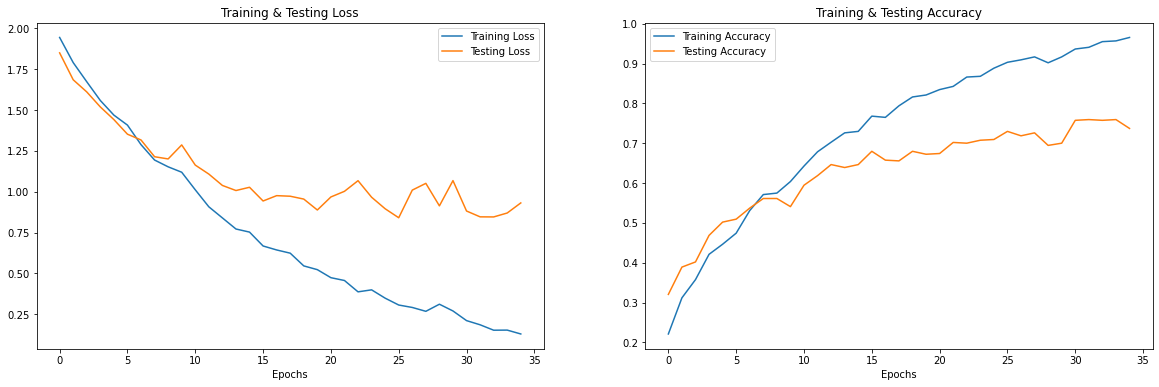

Random State : = 17
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 35ms/step - loss: 1.8956 - accuracy: 0.2634 - val_loss: 1.6836 - val_accuracy: 0.3920
Epoch 2/35
49/49 [==============================] - 1s 25ms/step - loss: 1.7006 - accuracy: 0.3688 - val_loss: 1.5433 - val_accuracy: 0.4244
Epoch 3/35
49/49 [==============================] - 1s 26ms/step - loss: 1.5637 - accuracy: 0.4064 - val_loss: 1.5112 - val_accuracy: 0.4583
Epoch 4/35
49/49 [==============================] - 1s 25ms/step - loss: 1.4593 - accuracy: 0.4568 - val_loss: 1.3887 - val_accuracy: 0.4583
Epoch 5/35
49/49 [==============================] - 1s 25ms/step - loss: 1.3933 - accuracy: 0.4697 - val_loss: 1.3771 - val_accuracy: 0.4907
Epoch 6/35
49/49 [==============================] - 1s 26ms/step - loss: 1.2704 - accuracy: 0.5334 - val_loss: 1.2

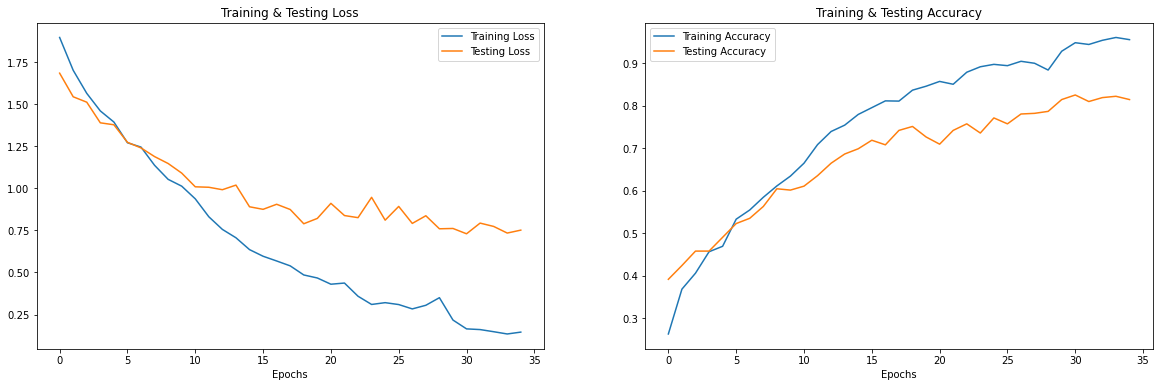

Random State : = 17
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 27ms/step - loss: 1.8980 - accuracy: 0.2667 - val_loss: 1.7133 - val_accuracy: 0.3593
Epoch 2/35
61/61 [==============================] - 1s 22ms/step - loss: 1.6798 - accuracy: 0.3609 - val_loss: 1.5796 - val_accuracy: 0.4136
Epoch 3/35
61/61 [==============================] - 1s 21ms/step - loss: 1.5371 - accuracy: 0.4107 - val_loss: 1.4939 - val_accuracy: 0.4506
Epoch 4/35
61/61 [==============================] - 1s 20ms/step - loss: 1.4550 - accuracy: 0.4523 - val_loss: 1.3848 - val_accuracy: 0.4864
Epoch 5/35
61/61 [==============================] - 1s 21ms/step - loss: 1.3259 - accuracy: 0.5140 - val_loss: 1.3377 - val_accuracy: 0.5049
Epoch 6/35
61/61 [==============================] - 1s 20ms/step - loss: 1.2640 - accuracy: 0.5346 - val_loss: 1.2

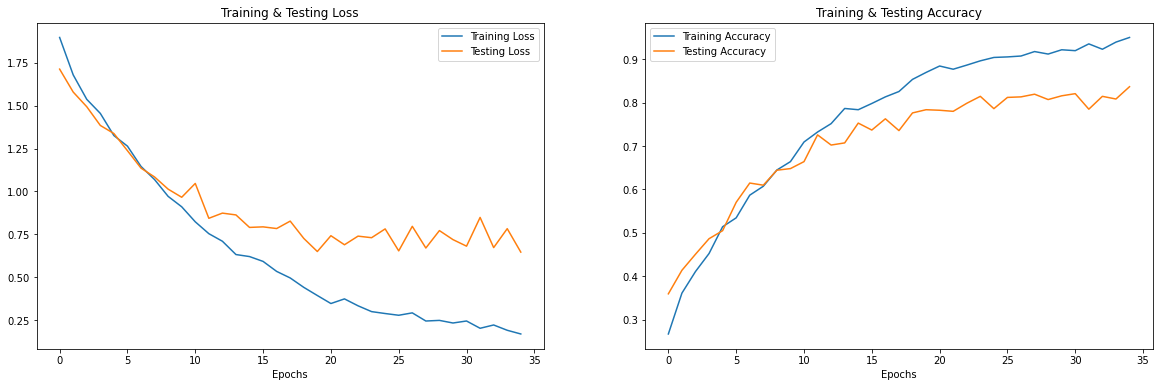

Random State : = 17
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 2s 29ms/step - loss: 1.9024 - accuracy: 0.2747 - val_loss: 1.7157 - val_accuracy: 0.3588
Epoch 2/35
65/65 [==============================] - 1s 21ms/step - loss: 1.6642 - accuracy: 0.3638 - val_loss: 1.5093 - val_accuracy: 0.4329
Epoch 3/35
65/65 [==============================] - 1s 21ms/step - loss: 1.5306 - accuracy: 0.4255 - val_loss: 1.4316 - val_accuracy: 0.4884
Epoch 4/35
65/65 [==============================] - 1s 20ms/step - loss: 1.4114 - accuracy: 0.4738 - val_loss: 1.3511 - val_accuracy: 0.4873
Epoch 5/35
65/65 [==============================] - 1s 23ms/step - loss: 1.3274 - accuracy: 0.5035 - val_loss: 1.2873 - val_accuracy: 0.5567
Epoch 6/35
65/65 [==============================] - 1s 22ms/step - loss: 1.2171 - accuracy: 0.5598 - val_loss: 1.2

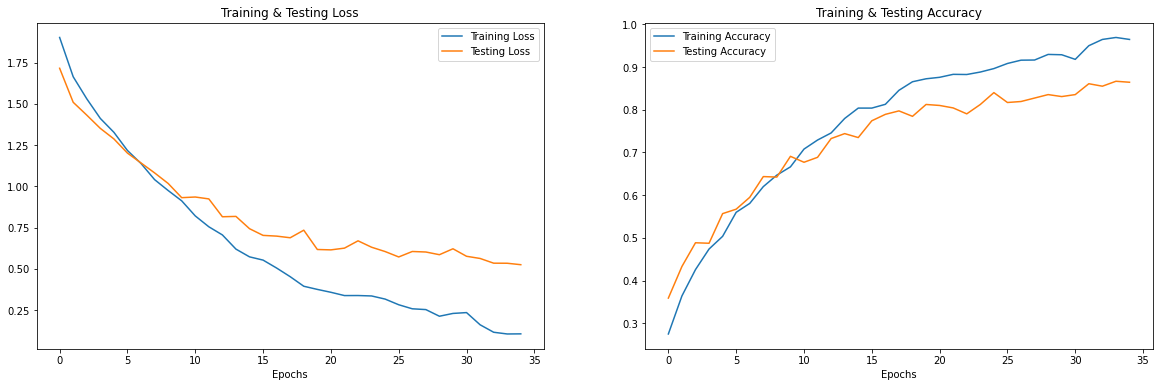

Random State : = 24
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 34ms/step - loss: 1.9393 - accuracy: 0.2290 - val_loss: 1.7953 - val_accuracy: 0.3111
Epoch 2/35
41/41 [==============================] - 1s 26ms/step - loss: 1.7800 - accuracy: 0.3253 - val_loss: 1.6486 - val_accuracy: 0.3722
Epoch 3/35
41/41 [==============================] - 2s 38ms/step - loss: 1.6231 - accuracy: 0.4037 - val_loss: 1.5613 - val_accuracy: 0.4111
Epoch 4/35
41/41 [==============================] - 1s 34ms/step - loss: 1.5228 - accuracy: 0.4296 - val_loss: 1.5623 - val_accuracy: 0.4204
Epoch 5/35
41/41 [==============================] - 1s 32ms/step - loss: 1.4740 - accuracy: 0.4611 - val_loss: 1.5567 - val_accuracy: 0.4241
Epoch 6/35
41/41 [==============================] - 2s 40ms/step - loss: 1.3741 - accuracy: 0.4988 - val_loss: 1.3

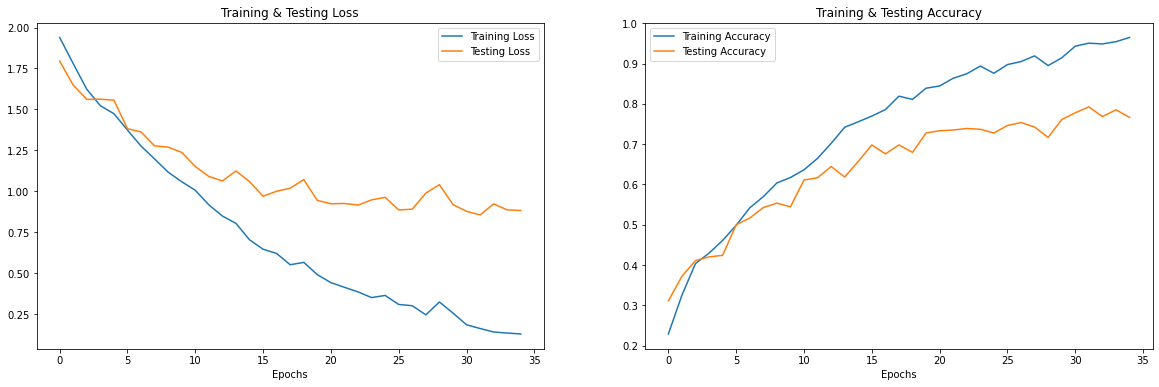

Random State : = 24
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 25ms/step - loss: 1.9220 - accuracy: 0.2459 - val_loss: 1.7601 - val_accuracy: 0.3287
Epoch 2/35
49/49 [==============================] - 1s 21ms/step - loss: 1.7324 - accuracy: 0.3452 - val_loss: 1.5872 - val_accuracy: 0.4167
Epoch 3/35
49/49 [==============================] - 1s 23ms/step - loss: 1.5836 - accuracy: 0.3909 - val_loss: 1.4911 - val_accuracy: 0.4228
Epoch 4/35
49/49 [==============================] - 1s 23ms/step - loss: 1.4824 - accuracy: 0.4378 - val_loss: 1.4707 - val_accuracy: 0.4259
Epoch 5/35
49/49 [==============================] - 1s 21ms/step - loss: 1.3772 - accuracy: 0.4841 - val_loss: 1.3668 - val_accuracy: 0.4969
Epoch 6/35
49/49 [==============================] - 1s 21ms/step - loss: 1.2853 - accuracy: 0.5298 - val_loss: 1.3

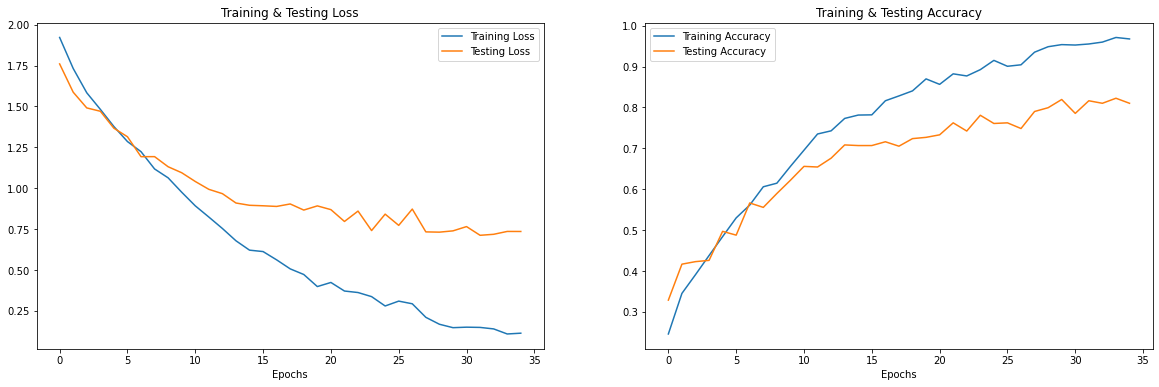

Random State : = 24
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 23ms/step - loss: 1.9131 - accuracy: 0.2420 - val_loss: 1.8214 - val_accuracy: 0.3099
Epoch 2/35
61/61 [==============================] - 1s 21ms/step - loss: 1.6971 - accuracy: 0.3630 - val_loss: 1.5634 - val_accuracy: 0.4111
Epoch 3/35
61/61 [==============================] - 1s 21ms/step - loss: 1.5455 - accuracy: 0.4148 - val_loss: 1.4851 - val_accuracy: 0.4198
Epoch 4/35
61/61 [==============================] - 1s 22ms/step - loss: 1.4398 - accuracy: 0.4621 - val_loss: 1.4227 - val_accuracy: 0.4840
Epoch 5/35
61/61 [==============================] - 1s 22ms/step - loss: 1.3529 - accuracy: 0.4947 - val_loss: 1.3096 - val_accuracy: 0.5037
Epoch 6/35
61/61 [==============================] - 1s 20ms/step - loss: 1.2404 - accuracy: 0.5519 - val_loss: 1.2

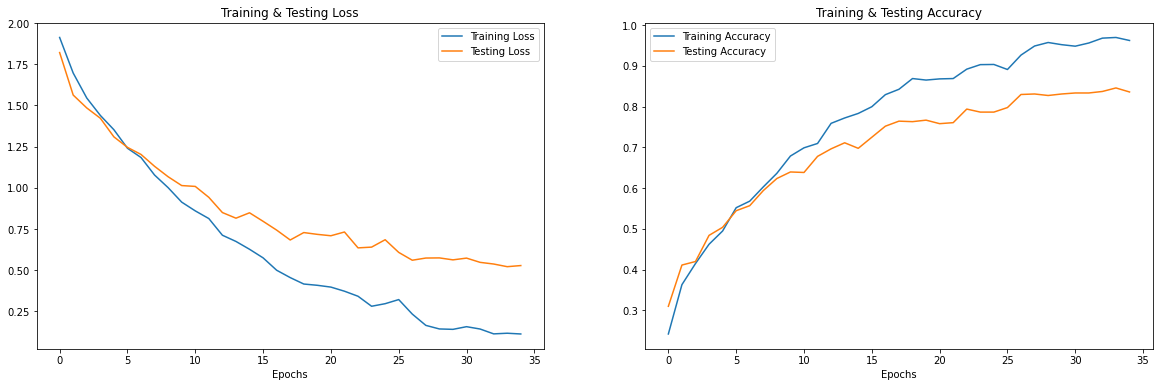

Random State : = 24
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 2s 28ms/step - loss: 1.9033 - accuracy: 0.2539 - val_loss: 1.7561 - val_accuracy: 0.3310
Epoch 2/35
65/65 [==============================] - 2s 24ms/step - loss: 1.6811 - accuracy: 0.3669 - val_loss: 1.5345 - val_accuracy: 0.3958
Epoch 3/35
65/65 [==============================] - 2s 24ms/step - loss: 1.5265 - accuracy: 0.4255 - val_loss: 1.4825 - val_accuracy: 0.4363
Epoch 4/35
65/65 [==============================] - 2s 23ms/step - loss: 1.4212 - accuracy: 0.4707 - val_loss: 1.3476 - val_accuracy: 0.4803
Epoch 5/35
65/65 [==============================] - 2s 23ms/step - loss: 1.3056 - accuracy: 0.5347 - val_loss: 1.3171 - val_accuracy: 0.5116
Epoch 6/35
65/65 [==============================] - 2s 25ms/step - loss: 1.1997 - accuracy: 0.5617 - val_loss: 1.2

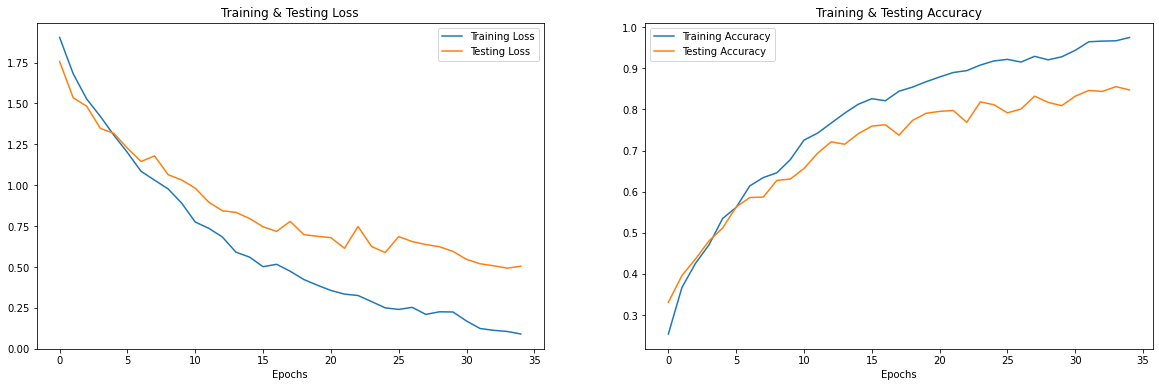

Random State : = 51
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
41/41 [==============================] - 2s 35ms/step - loss: 1.9435 - accuracy: 0.2346 - val_loss: 1.8012 - val_accuracy: 0.3722
Epoch 2/35
41/41 [==============================] - 1s 23ms/step - loss: 1.7612 - accuracy: 0.3130 - val_loss: 1.6335 - val_accuracy: 0.3981
Epoch 3/35
41/41 [==============================] - 1s 26ms/step - loss: 1.6305 - accuracy: 0.3790 - val_loss: 1.5283 - val_accuracy: 0.4296
Epoch 4/35
41/41 [==============================] - 1s 24ms/step - loss: 1.5326 - accuracy: 0.4191 - val_loss: 1.4492 - val_accuracy: 0.4648
Epoch 5/35
41/41 [==============================] - 1s 25ms/step - loss: 1.4935 - accuracy: 0.4290 - val_loss: 1.4502 - val_accuracy: 0.4722
Epoch 6/35
41/41 [==============================] - 1s 26ms/step - loss: 1.3865 - accuracy: 0.4883 - val_loss: 1.3

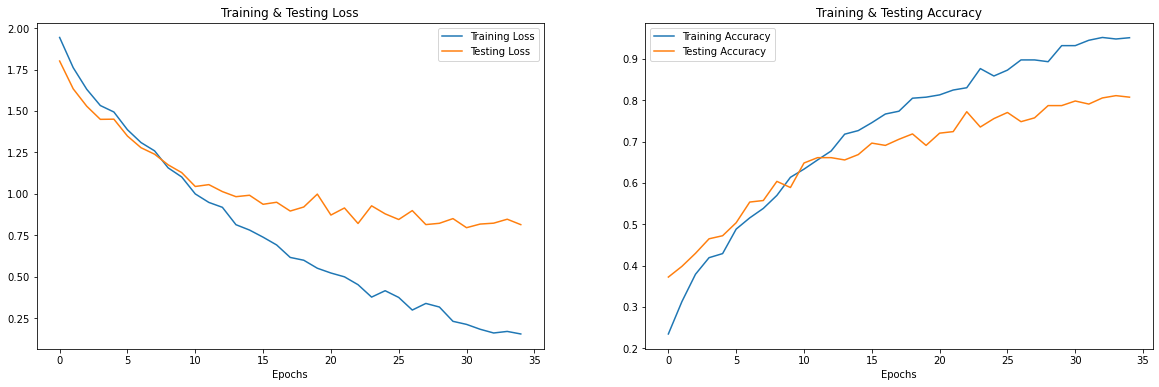

Random State : = 51
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
49/49 [==============================] - 2s 34ms/step - loss: 1.9584 - accuracy: 0.2248 - val_loss: 1.7884 - val_accuracy: 0.3040
Epoch 2/35
49/49 [==============================] - 1s 28ms/step - loss: 1.7922 - accuracy: 0.3086 - val_loss: 1.6591 - val_accuracy: 0.3873
Epoch 3/35
49/49 [==============================] - 2s 31ms/step - loss: 1.6409 - accuracy: 0.3868 - val_loss: 1.5381 - val_accuracy: 0.4151
Epoch 4/35
49/49 [==============================] - 1s 26ms/step - loss: 1.5600 - accuracy: 0.4146 - val_loss: 1.4493 - val_accuracy: 0.4645
Epoch 5/35
49/49 [==============================] - 2s 37ms/step - loss: 1.4495 - accuracy: 0.4465 - val_loss: 1.3533 - val_accuracy: 0.4892
Epoch 6/35
49/49 [==============================] - 1s 26ms/step - loss: 1.3918 - accuracy: 0.4758 - val_loss: 1.3

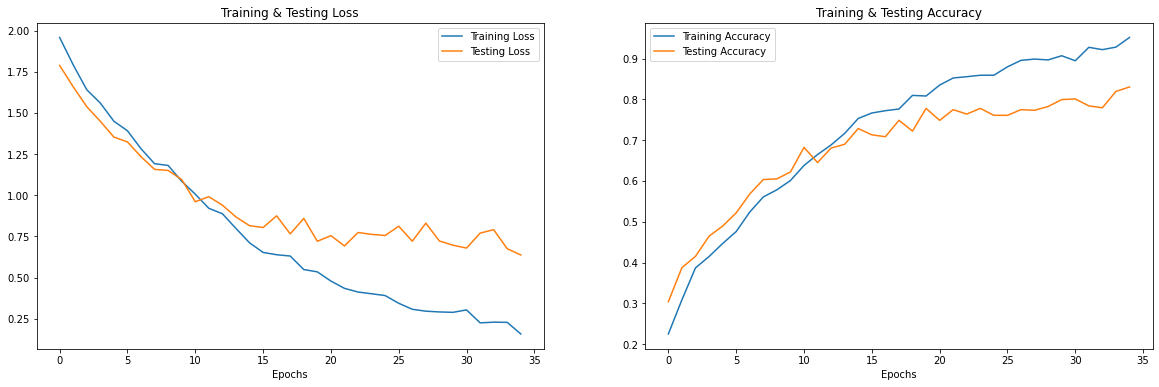

Random State : = 51
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
61/61 [==============================] - 2s 30ms/step - loss: 1.9034 - accuracy: 0.2461 - val_loss: 1.7158 - val_accuracy: 0.3864
Epoch 2/35
61/61 [==============================] - 2s 25ms/step - loss: 1.6956 - accuracy: 0.3580 - val_loss: 1.5668 - val_accuracy: 0.4222
Epoch 3/35
61/61 [==============================] - 1s 24ms/step - loss: 1.5827 - accuracy: 0.4021 - val_loss: 1.4656 - val_accuracy: 0.4519
Epoch 4/35
61/61 [==============================] - 2s 25ms/step - loss: 1.4548 - accuracy: 0.4461 - val_loss: 1.3487 - val_accuracy: 0.4951
Epoch 5/35
61/61 [==============================] - 2s 31ms/step - loss: 1.3850 - accuracy: 0.4638 - val_loss: 1.2718 - val_accuracy: 0.5086
Epoch 6/35
61/61 [==============================] - 2s 28ms/step - loss: 1.2750 - accuracy: 0.5358 - val_loss: 1.1

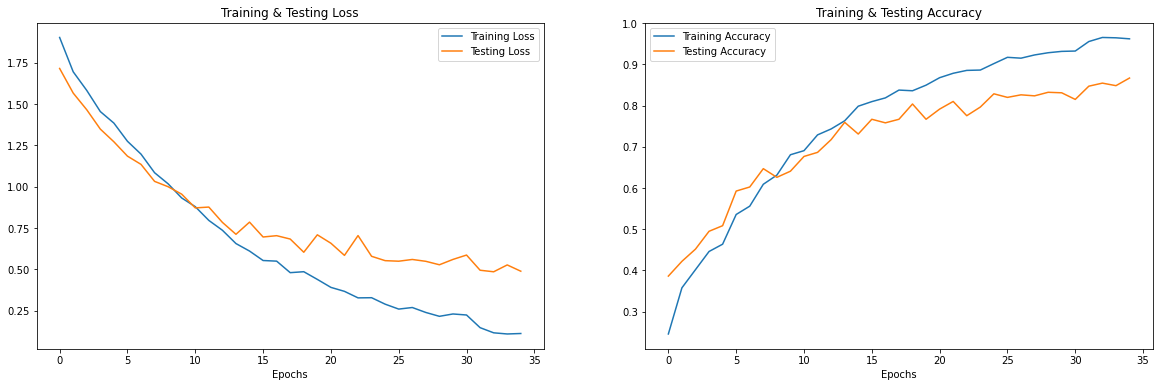

Random State : = 51
-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
65/65 [==============================] - 3s 33ms/step - loss: 1.9035 - accuracy: 0.2515 - val_loss: 1.6902 - val_accuracy: 0.4062
Epoch 2/35
65/65 [==============================] - 2s 24ms/step - loss: 1.6685 - accuracy: 0.3708 - val_loss: 1.5119 - val_accuracy: 0.4167
Epoch 3/35
65/65 [==============================] - 2s 24ms/step - loss: 1.5584 - accuracy: 0.4255 - val_loss: 1.4561 - val_accuracy: 0.4444
Epoch 4/35
65/65 [==============================] - 2s 24ms/step - loss: 1.4466 - accuracy: 0.4591 - val_loss: 1.3412 - val_accuracy: 0.5116
Epoch 5/35
65/65 [==============================] - 2s 24ms/step - loss: 1.3448 - accuracy: 0.4923 - val_loss: 1.2458 - val_accuracy: 0.5405
Epoch 6/35
65/65 [==============================] - 2s 28ms/step - loss: 1.2753 - accuracy: 0.5336 - val_loss: 1.1

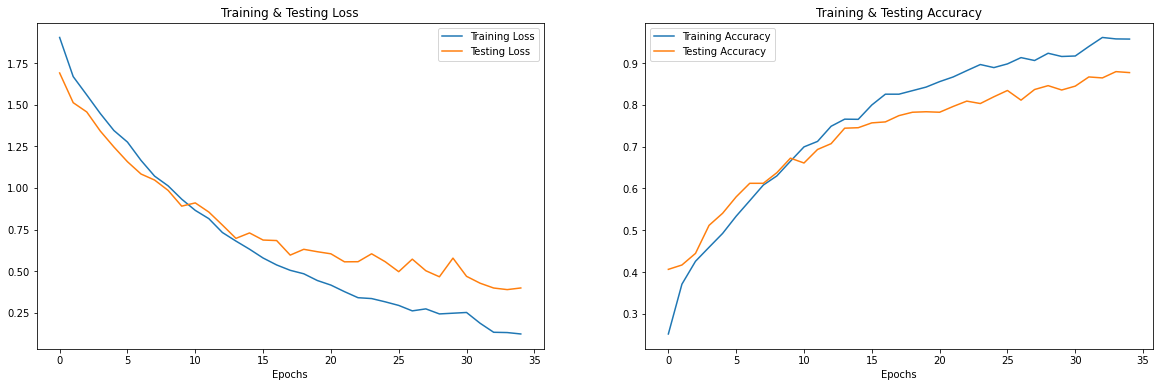

In [84]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_train_test_xy(),total=5):
    Model_3_dict = {}
    Histories_3 = {}
    for k in cg:
        Model_3_dict[k] = model_3(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 3")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Histories_3[k] = Model_3_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    # verbose=0,
                                    callbacks=[rlrp])
        
        
        print("-------------------")
        print(f"Traing is done for Model 3")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        
        model_3_acc_matrix[k].append(loss_accuracy_details(Model_3_dict[k],
                                                           Histories_3[k],
                                                           epoch,x_tests[k],
                                                           y_tests[k]
                                                           ))
        
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_3',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'model_3',k))
        Model_3_dict[k].save(os.path.join("Models",'model_3',k,f"model_3_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [85]:
model_3_acc_Df = pd.DataFrame(model_3_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
model_3_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'model_3_acc_mat.csv'))
model_3_acc_Df.head()

,10,13,17,24,51
a,74.490738,75.879627,75.324076,74.861109,79.259259
b,78.877312,78.587961,81.423610,80.497688,80.555558
c,85.000002,84.166664,82.222223,82.314813,85.092592
d,84.722221,85.185188,84.837961,85.763890,84.953701


In [86]:
model_3_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,75.962962,79.988426,83.759259,85.092592
std,1.914563,1.207955,1.408199,0.412467
min,74.490738,78.587961,82.222223,84.722221
25%,74.861109,78.877312,82.314813,84.837961
50%,75.324076,80.497688,84.166664,84.953701
75%,75.879627,80.555558,85.000002,85.185188
max,79.259259,81.423610,85.092592,85.763890
